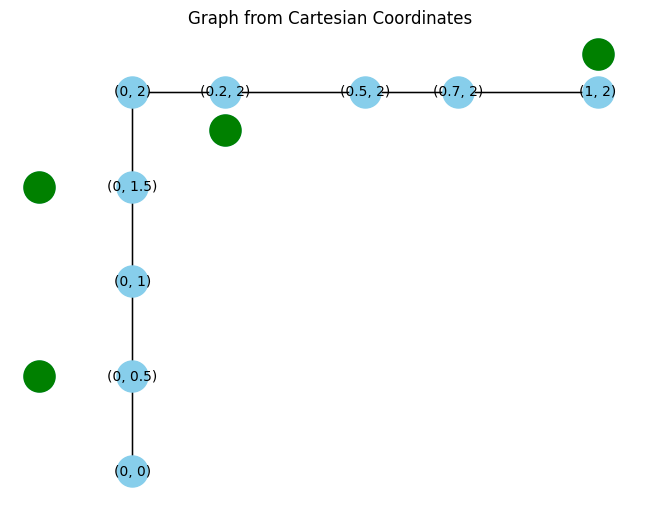

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_graph_from_coordinates(coordinates, separate_points=None, separate_points_labels=None):
    G = nx.Graph()
    for i, coord in enumerate(coordinates):
        G.add_node(i, pos=coord)
    for i in range(len(coordinates) - 1):
        dist = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[i + 1]))
        G.add_edge(i, i + 1, weight=dist)
    if separate_points:
        for i, coord in enumerate(separate_points):
            G.add_node(len(coordinates) + i, pos=coord)

    pos = nx.get_node_attributes(G, 'pos')
    labels = {i: f"{coord}" for i, coord in enumerate(coordinates)}

    nx.draw(G, pos, with_labels=True, labels=labels, node_size=500, node_color='skyblue', font_size=10)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1.0, alpha=0.5)
    
    if separate_points:
        nx.draw_networkx_nodes(G, pos, nodelist=range(len(coordinates), len(coordinates) + len(separate_points)), node_size=500, node_color='green')
        if separate_points_labels:
            for i, coord in enumerate(separate_points):
                plt.text(coord[0], coord[1], f"Prob: {separate_points_labels[i]:.4f}\n", fontsize=10, ha='center', va='center', color='black')

    plt.title('Graph from Cartesian Coordinates')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

# states = [(0,0),(0,0.5),(0,1),(0,1.5),(0,2),(0.2,2),(0.5, 2),(0.7,2),(1,2)]
# observations = [(0,0.5),(0,1.5), (0.2, 2), (0.7, 2)]

states = [(0,0), (0,0.5), (0,1), (0,1.5), (0,2), (0.2,2), (0.5,2), (0.7,2), (1,2)]
observations = [(-0.2,0.5), (-0.2,1.5), (0.2,1.8), (1,2.2)]
# observations = [(0.01,0.52), (-0.02,0.98), (0.18,2.02), (0.72,1.95)]


pairwise_distances = []
for i in range(len(observations) - 1):
    x1, y1 = observations[i]
    x2, y2 = observations[i + 1]
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    pairwise_distances.append(distance)
plot_graph_from_coordinates(states, observations)


In [2]:
import numpy as np
from math import exp, sqrt, pi
states = np.array([(0,0), (0,0.5), (0,1), (0,1.5), (0,2), (0.2,2), (0.5,2), (0.7,2), (1,2)])
observations = np.array([(-0.2,0.5), (-0.2,1.5), (0.2,1.8), (1,2.2)])

pairwise_distances = []
for i in range(len(observations) - 1):
    x1, y1 = observations[i]
    x2, y2 = observations[i + 1]
    distance = sqrt((x2 - x1)**2 + (y2 - y1)**2)
    pairwise_distances.append(distance)
TRANS = np.zeros((len(states), len(states), len(observations)-1))

beta = 0.95  

n = len(states)
for k in range(len(observations)-1):
    for i in range(n):
        for j in range(n):
            xtemp = np.linalg.norm(states[i] - states[j])
            dij = abs(xtemp - pairwise_distances[k])
            TRANS[i, j, k] = (1 / beta) * exp(-dij / beta)
        TRANS[i, :, k] = TRANS[i, :, k] / np.sum(TRANS[i, :, k])

sigztemp = []
for i in range(len(observations)):
    for j in range(len(states)):
        sigztemp.append(np.linalg.norm(observations[i] - states[j]))
sigz = 1.4 * np.median(sigztemp)

EMIS = np.zeros((len(states), len(observations)))
for i in range(len(observations)):
    for j in range(len(states)):
        EMIS[j, i] = (1 / (sqrt(2 * pi) * sigz)) * exp(-0.5 * ((np.linalg.norm(observations[i] - states[j])) / sigz) ** 2)

seq = [1, 2, 3, 4]
PRIOR = np.array([0.1, 0.8] + [(0.1 / 7)] * 7)

T = len(seq)  
n = EMIS.shape[0]  
score = np.zeros((n, T))
pred = np.zeros((n, T))

for i in range(n):
    score[i, 0] = PRIOR[i] * EMIS[i, seq[0] - 1]

for t in range(1, T):
    for j in range(n):
        tscore = np.zeros(n)
        for k in range(n):
            tscore[k] = score[k, t - 1] * TRANS[k, j, t - 1] * EMIS[j, seq[t] - 1]
        score[j, t] = np.max(tscore)
        id = np.where(tscore == np.max(tscore))[0][0]
        pred[j, t] = id

IT = np.zeros(T, dtype=int)
IT[-1] = np.argmax(score[:, -1])

for t in range(T - 1, 0, -1):
    IT[t - 1] = int(pred[IT[t], t])

print(IT)

[1 3 5 8]


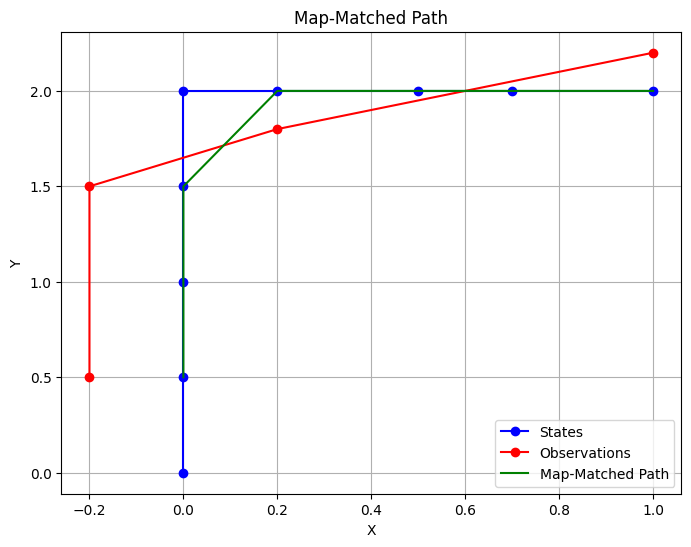

In [8]:
import numpy as np
import matplotlib.pyplot as plt

states = np.array([(0, 0), (0, 0.5), (0, 1), (0, 1.5), (0, 2), (0.2, 2), (0.5, 2), (0.7, 2), (1, 2)])
observations = np.array([(-0.2, 0.5), (-0.2, 1.5), (0.2, 1.8), (1, 2.2)])

# Map matching function to find the nearest state for each observation
def map_match(observation, states):
    min_distance = float('inf')
    matched_state = None
    for state in states:
        distance = np.linalg.norm(observation - state)
        if distance < min_distance:
            min_distance = distance
            matched_state = state
    return matched_state

# Map matching observations to the nearest states
matched_states = [map_match(obs, states) for obs in observations]

# Plotting the map-matched path
plt.figure(figsize=(8, 6))
plt.plot(states[:, 0], states[:, 1], 'bo-', label='States')
plt.plot([obs[0] for obs in observations], [obs[1] for obs in observations], 'ro-', label='Observations')
plt.plot([state[0] for state in matched_states], [state[1] for state in matched_states], 'g-', label='Map-Matched Path')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Map-Matched Path')
plt.legend()
plt.grid(True)
plt.show()


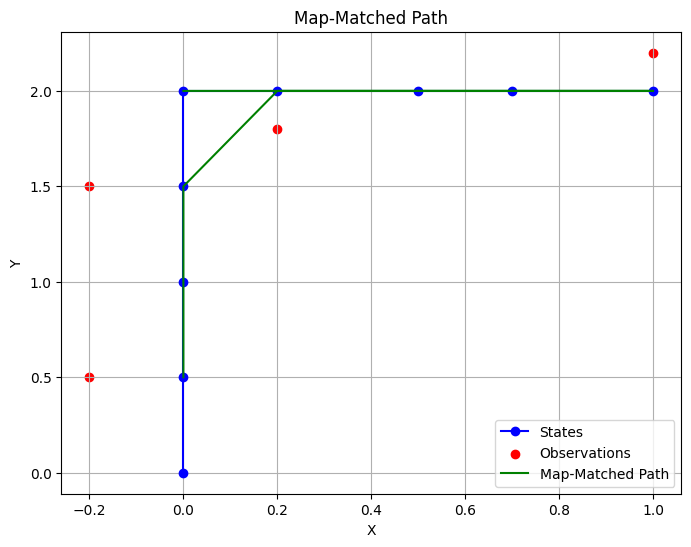

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

states = np.array([(0, 0), (0, 0.5), (0, 1), (0, 1.5), (0, 2), (0.2, 2), (0.5, 2), (0.7, 2), (1, 2)])
observations = np.array([(-0.2, 0.5), (-0.2, 1.5), (0.2, 1.8), (1, 2.2)])

# Map matching function to find the nearest state for each observation
def map_match(observation, states):
    min_distance = float('inf')
    matched_state = None
    for state in states:
        distance = np.linalg.norm(observation - state)
        if distance < min_distance:
            min_distance = distance
            matched_state = state
    return matched_state

# Map matching observations to the nearest states
matched_states = [map_match(obs, states) for obs in observations]

# Ensure the path goes through (0, 2)
state_0_2 = np.array((0, 2))
if not any(np.array_equal(state, state_0_2) for state in matched_states):
    matched_states.append(state_0_2)

# Sort matched states by the y-coordinate to ensure correct order
matched_states = sorted(matched_states, key=lambda x: x[1])

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(states[:, 0], states[:, 1], 'bo-', label='States')
plt.scatter([obs[0] for obs in observations], [obs[1] for obs in observations], c='r', label='Observations')
plt.plot([state[0] for state in matched_states], [state[1] for state in matched_states], 'g-', label='Map-Matched Path')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Map-Matched Path')
plt.legend()
plt.grid(True)
plt.show()


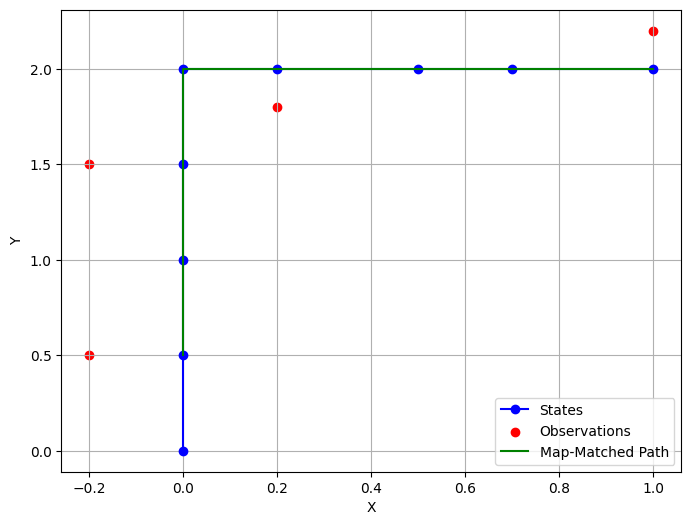

In [15]:
import numpy as np
import matplotlib.pyplot as plt

states = np.array([(0, 0), (0, 0.5), (0, 1), (0, 1.5), (0, 2), (0.2, 2), (0.5, 2), (0.7, 2), (1, 2)])
observations = np.array([(-0.2, 0.5), (-0.2, 1.5), (0.2, 1.8), (1, 2.2)])

# Map matching function to find the nearest state for each observation
def map_match(observation, states):
    min_distance = float('inf')
    matched_state = None
    for state in states:
        distance = np.linalg.norm(observation - state)
        if distance < min_distance:
            min_distance = distance
            matched_state = state
    return matched_state

# Map matching observations to the nearest states
matched_states = [map_match(obs, states) for obs in observations]

# Ensure the path goes through (0, 2)
state_0_2 = np.array([0, 2])
if not any(np.array_equal(state, state_0_2) for state in matched_states):
    matched_states.append(state_0_2)

# Sort matched states by their order in the original states array
state_indices = {tuple(state): idx for idx, state in enumerate(states)}
matched_states.sort(key=lambda state: state_indices[tuple(state)])

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(states[:, 0], states[:, 1], 'bo-', label='States')
plt.scatter(observations[:, 0], observations[:, 1], c='r', label='Observations')
plt.plot([state[0] for state in matched_states], [state[1] for state in matched_states], 'g-', label='Map-Matched Path')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()
